# Calculate and Visualize K-function Statistics 

In [1]:
from pathlib import Path
import getpass

import pandas as pd
import numpy as np
from ruamel.yaml import YAML
from typing import Any

from IPython.display import Image

## Configuration

Set global variables that define the slide file we'll be working on, and the directory where our results will be wriiten.

In this example, we'll download a publically available slide from the `Kitware` site to a local directory, named with the slide ID.  The results of each step will written to separate subdirectories of that folder.

In [2]:
USER = getpass.getuser()
SLIDE_URL = "https://data.kitware.com/api/v1/item/61bcaf8f4acac99f42e95620/download"
SLIDE_ID = "01OV008-308ad404-7079-4ff8-8232-12ee2e"
SLIDE_DIR = f"/gpfs/mskmind_ess/{USER}/tmp/slides/{SLIDE_ID}"
SLIDE = f"{SLIDE_DIR}/{SLIDE_ID}.svs"
WORKDIR = SLIDE_DIR

#### Download the slide

In [3]:
! mkdir -p {SLIDE_DIR}
! [[ -f {SLIDE} ]] || wget -O {SLIDE} --no-check-certificate {SLIDE_URL}

In [4]:
!ls -l {SLIDE}

-rw-r--r-- 1 pollardw pollardw 237047223 Aug  8 13:11 /gpfs/mskmind_ess/pollardw/tmp/slides/01OV008-308ad404-7079-4ff8-8232-12ee2e/01OV008-308ad404-7079-4ff8-8232-12ee2e.svs


In [5]:
from tiffslide import TiffSlide
assert Path(SLIDE).exists()
TiffSlide(Path(SLIDE).open('rb')).dimensions

(53760, 54840)

#### Dask
Luna uses Dask to parallelize many calculations.  It's not strictly necessary, but it's helpful to have Dask cluster up before running Luna.  
If you set the environment variable `LUNA_DASK_SCHEDULER` to the `ip:port` address of the Dask scheduler, Luna will use that cluster.
Otherwise, Luna will spin up an ephemeral LocalCluster.

In [6]:
!echo "Dask scheduler:" $LUNA_DASK_SCHEDULER

Dask scheduler: tcp://10.254.130.14:8786


#### Metadata file
Every stage of this processing pipeline writes its output files to its own subfolder of the working directory.  A `metadata.yml` file is written to each of these, as well, summarizing the parameters of the calculation, along with the input and output files.
This function reads the `metadata.yml` file from the given directory and returns a dict representing that metadata.  We'll use this to get the output file name for each step.


In [7]:
def read_metadata(dir: str) -> dict[str, Any]:
    yaml = YAML(typ="safe")
    return yaml.load((Path(dir) / "metadata.yml").read_text())

## First, run stardist cell detection + cell measurements
* a cell expansion size of `8 um`
* `40 cores` for speedup
* we are using a `BRIGHTFIELD_H_DAB` image

In [8]:
from luna.pathology.cli.run_stardist_cell_detection import stardist_simple
STARDIST_DIR = f"{WORKDIR}/stardist_v3"
Path(STARDIST_DIR).mkdir(exist_ok=True)

stardist_simple(
    SLIDE,
    cell_expansion_size = 8,
    image_type = "BRIGHTFIELD_H_DAB",
    output_urlpath = STARDIST_DIR,
    num_cores = 40,
)

2023-08-10 10:54:53.688 | INFO     | luna.pathology.cli.run_stardist_cell_detection:stardist_simple:49 - outputs already exist: /gpfs/mskmind_ess/pollardw/tmp/slides/01OV008-308ad404-7079-4ff8-8232-12ee2e/stardist_v3
2023-08-10 10:54:53.689 | DEBUG    | luna.common.utils:wrapper:146 - stardist_simple ran in 0.0s


If we look at the output directory, we can see that QuPath has written `.geojson` and `.tsv` files for the identified cells, in addition to the `.parquet` file from luna.

In [9]:
!ls -l {STARDIST_DIR}

total 5620833
-rw-r--r-- 1 pollardw pollardw   91447499 Aug  8 13:54 01OV008-308ad404-7079-4ff8-8232-12ee2e_cell_objects.parquet
-rw-r--r-- 1 root     root     5299580289 Aug  8 13:53 cell_detections.geojson
-rw-r--r-- 1 root     root      364685030 Aug  8 13:49 cell_detections.tsv
-rw-r--r-- 1 pollardw pollardw        799 Aug  8 14:08 metadata.yml
-rw-r--r-- 1 pollardw pollardw        801 Aug  8 14:05 metadata.yml~


In [10]:
stardist = read_metadata(STARDIST_DIR)
cell_objects_file = stardist["cell_objects"]

In [11]:
stardist = read_metadata(STARDIST_DIR)
cell_objects_file = stardist.get("cell_objects")
df = pd.read_parquet(cell_objects_file)
df.columns

Index(['Image', 'Name', 'Class', 'Parent', 'ROI', 'x_coord', 'y_coord',
       'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm',
       'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm',
       'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm',
       'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm',
       'Cell: Min diameter µm', 'Nucleus/Cell area ratio',
       'Hematoxylin: Nucleus: Mean', 'Hematoxylin: Nucleus: Median',
       'Hematoxylin: Nucleus: Min', 'Hematoxylin: Nucleus: Max',
       'Hematoxylin: Nucleus: Std.Dev.', 'Hematoxylin: Cytoplasm: Mean',
       'Hematoxylin: Cytoplasm: Median', 'Hematoxylin: Cytoplasm: Min',
       'Hematoxylin: Cytoplasm: Max', 'Hematoxylin: Cytoplasm: Std.Dev.',
       'Hematoxylin: Membrane: Mean', 'Hematoxylin: Membrane: Median',
       'Hematoxylin: Membrane: Min', 'Hematoxylin: Membrane: Max',
       'Hematoxylin: Membrane: Std.Dev.', 'Hematoxylin: Cell: Mean',
       'H

## Calculate K-function statistics
We will use...
* a sliding window of size 1000 with a stride of 300,
* a radius of 160 um, for
* the nucleus-size values determined by Stardist. 

In [12]:
from luna.pathology.cli.extract_kfunction_statistics import cli as extract_kfunction_cli
KFUNCT_DIR = f"{WORKDIR}/kfunct_v3"
Path(KFUNCT_DIR).mkdir(exist_ok=True)

extract_kfunction_cli(
    input_cell_objects_urlpath = cell_objects_file,
    tile_size = 1000,
    intensity_label = 'Nucleus: Area µm^2',
    tile_stride = 300,
    radius = 160,
    output_urlpath = KFUNCT_DIR,
)

2023-08-10 10:54:59.020 | INFO     | luna.pathology.cli.extract_kfunction_statistics:extract_kfunction:112 - Submitting tasks...


  0%|          | 0/1332 [00:00<?, ?it/s]

2023-08-10 10:55:58.148 | INFO     | luna.pathology.cli.extract_kfunction_statistics:extract_kfunction:134 - Waiting for all tasks to complete...
2023-08-10 10:56:00.821 | INFO     | luna.pathology.cli.extract_kfunction_statistics:extract_kfunction:157 - Generated k-function feature data:
2023-08-10 10:56:00.822 | INFO     | luna.pathology.cli.extract_kfunction_statistics:extract_kfunction:158 -               x_coord  y_coord  xy_extent  tile_size tile_units  \
address                                                           
x1345_y1373      1345     1373       1000       1000         um   
x1345_y1673      1345     1673       1000       1000         um   
x1345_y1973      1345     1973       1000       1000         um   
x1345_y2273      1345     2273       1000       1000         um   
x1345_y2573      1345     2573       1000       1000         um   
...               ...      ...        ...        ...        ...   
x11845_y7673    11845     7673       1000       1000         um  

In [13]:
kfunct = read_metadata(KFUNCT_DIR)
slide_tiles_file = kfunct.get("slide_tiles")
pd.read_parquet(slide_tiles_file).columns

Index(['x_coord', 'y_coord', 'xy_extent', 'tile_size', 'tile_units',
       'ikfunction_r160_stainNucleus_Area_µm^2',
       'ikfunction_r160_stainNucleus_Area_µm^2_norm'],
      dtype='object')

In [14]:
from luna.pathology.cli.extract_tile_statistics import cli as tile_statistics_cli
TILE_STATS_DIR = f"{WORKDIR}/tile_stats_v3"
Path(TILE_STATS_DIR).mkdir(exist_ok=True)

tile_statistics_cli(
    tiles_urlpath = slide_tiles_file,
    output_urlpath = TILE_STATS_DIR,  
)

2023-08-10 10:56:00.958 | INFO     | luna.pathology.cli.extract_tile_statistics:cli:49 -    ikfunction_r160_stainNucleus_Area_µm^2_nobs  \
0                                         1177   

   ikfunction_r160_stainNucleus_Area_µm^2_mean  \
0                                 14091.694908   

   ikfunction_r160_stainNucleus_Area_µm^2_variance  \
0                                     5.433245e+07   

   ikfunction_r160_stainNucleus_Area_µm^2_skewness  \
0                                        -0.412433   

   ikfunction_r160_stainNucleus_Area_µm^2_kurtosis  \
0                                        -0.587146   

   ikfunction_r160_stainNucleus_Area_µm^2_pct0  \
0                                    13.815175   

   ikfunction_r160_stainNucleus_Area_µm^2_pct25  \
0                                   10175.25598   

   ikfunction_r160_stainNucleus_Area_µm^2_pct50  \
0                                  14649.896486   

   ikfunction_r160_stainNucleus_Area_µm^2_pct75  \
0                       

Index(['ikfunction_r160_stainNucleus_Area_µm^2', 'ikfunction_r160_stainNucleus_Area_µm^2_norm'], dtype='object')


In [15]:
tile_stats = read_metadata(TILE_STATS_DIR)
feature_data_file = tile_stats.get("feature_data")
pd.read_parquet(feature_data_file).T

,0
ikfunction_r160_stainNucleus_Area_µm^2_nobs,1.177000e+03
ikfunction_r160_stainNucleus_Area_µm^2_mean,1.409169e+04
ikfunction_r160_stainNucleus_Area_µm^2_variance,5.433245e+07
ikfunction_r160_stainNucleus_Area_µm^2_skewness,-4.124328e-01
ikfunction_r160_stainNucleus_Area_µm^2_kurtosis,-5.871457e-01
ikfunction_r160_stainNucleus_Area_µm^2_pct0,1.381517e+01
ikfunction_r160_stainNucleus_Area_µm^2_pct25,1.017526e+04
ikfunction_r160_stainNucleus_Area_µm^2_pct50,1.464990e+04
ikfunction_r160_stainNucleus_Area_µm^2_pct75,1.989810e+04
ikfunction_r160_stainNucleus_Area_µm^2_pct100,2.727800e+04


In [16]:
pd.read_parquet(slide_tiles_file).columns

Index(['x_coord', 'y_coord', 'xy_extent', 'tile_size', 'tile_units',
       'ikfunction_r160_stainNucleus_Area_µm^2',
       'ikfunction_r160_stainNucleus_Area_µm^2_norm'],
      dtype='object')

In [17]:
from luna.pathology.cli.visualize_tile_labels_png import cli as visualize_tile_labels_cli
KFUNCT_VIZ_DIR = f"{WORKDIR}/kfunct_viz_v3"
Path(KFUNCT_VIZ_DIR).mkdir(exist_ok=True)

visualize_tile_labels_cli(
    slide_urlpath = SLIDE,
    tiles_urlpath = slide_tiles_file,
    plot_labels = ["ikfunction_r160_stainNucleus_Area_µm^2_norm"],
    requested_magnification = 1,
    mpp_units = True,
    output_urlpath = KFUNCT_VIZ_DIR,
)

2023-08-10 10:56:01.595 | DEBUG    | luna.common.utils:wrapper:146 - get_downscaled_thumbnail ran in 0.48s
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1177/1177 [00:00<00:00, 1303.96it/s]
2023-08-10 10:56:02.833 | INFO     | luna.pathology.cli.visualize_tile_labels_png:cli:79 - Saved ikfunction_r160_stainNucleus_Area_µm^2_norm visualization at /gpfs/mskmind_ess/pollardw/tmp/slides/01OV008-308ad404-7079-4ff8-8232-12ee2e/kfunct_viz_v3/tile_scores_and_labels_visualization_ikfunction_r160_stainNucleus_Area_µm^2_norm.png
2023-08-10 10:56:02.837 | DEBUG    | luna.common.utils:wrapper:146 - cli ran in 1.81s


In [18]:
kfunct_viz = read_metadata(KFUNCT_VIZ_DIR)
image_files = list(kfunct_viz['images'].values())
image_files

['/gpfs/mskmind_ess/pollardw/tmp/slides/01OV008-308ad404-7079-4ff8-8232-12ee2e/kfunct_viz_v3/tile_scores_and_labels_visualization_ikfunction_r160_stainNucleus_Area_µm^2_norm.png']

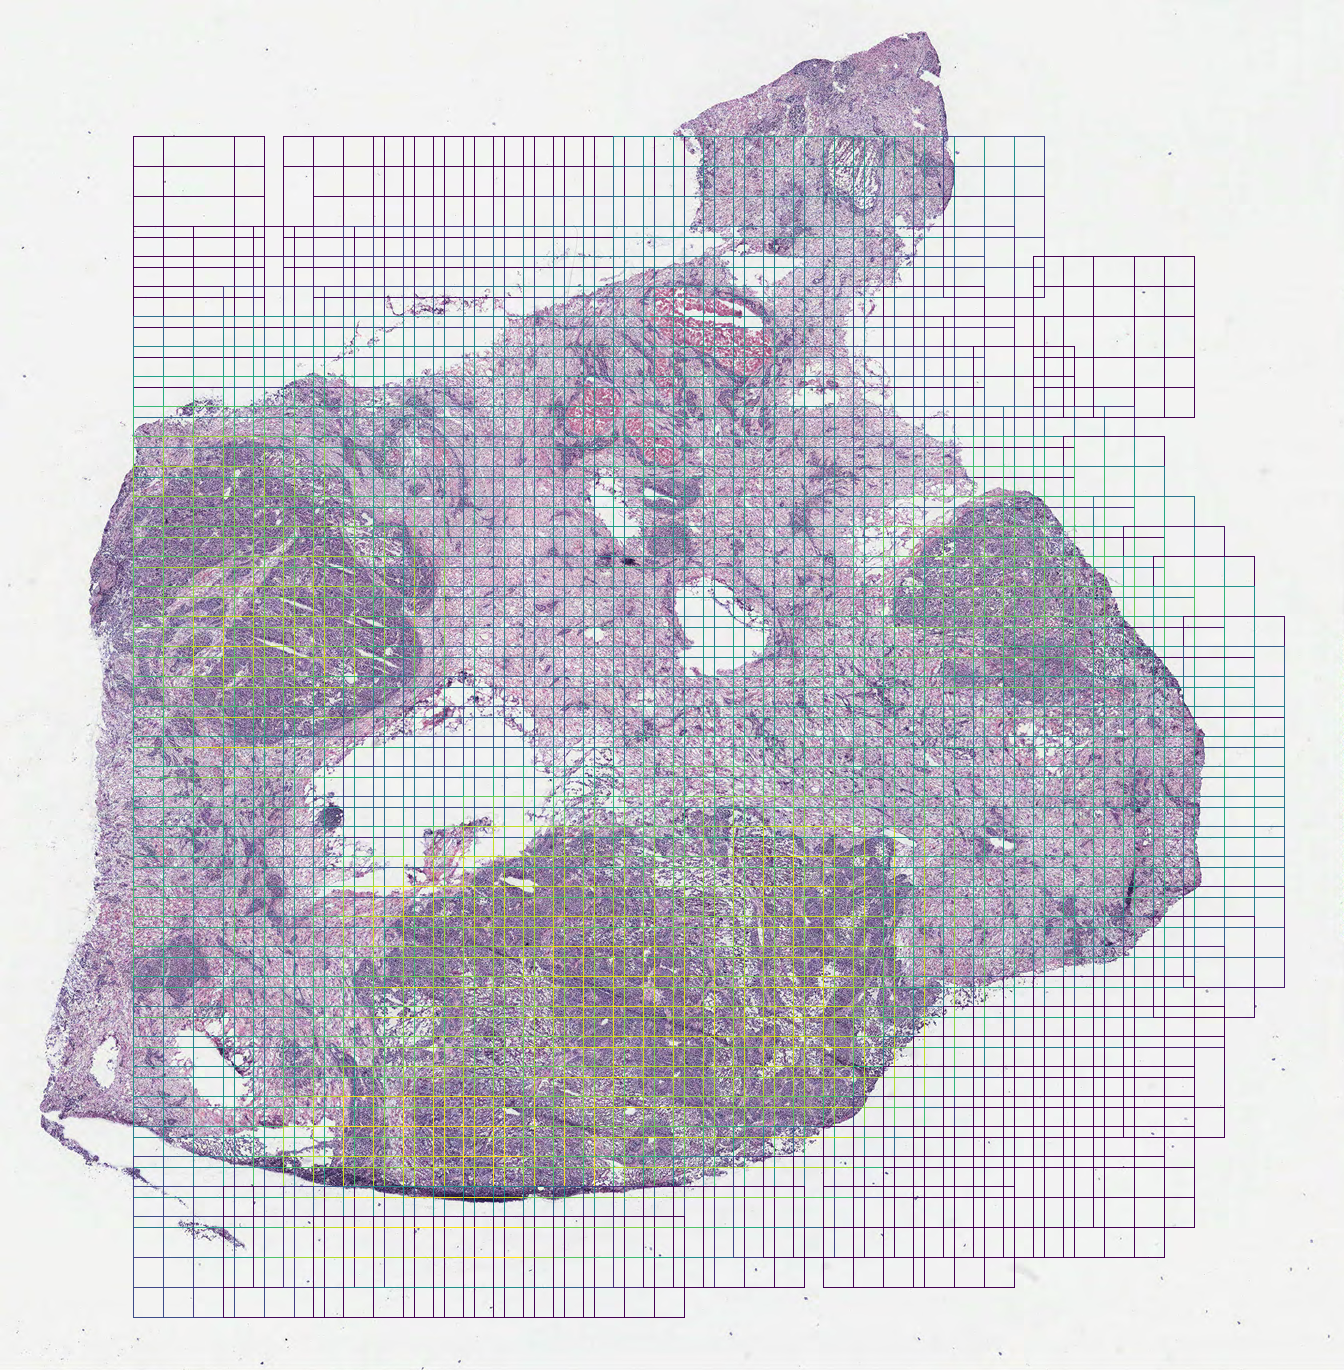

In [19]:
Image(image_files[0])

#### Done